In [11]:
%pip install numpy geopandas scipy folium statsmodels

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Clustering & Statistical
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Spatial
import geopandas as gpd
import folium
from folium import plugins
import os # Import os to check for file existence

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# IMPORT DATA & PENANGANAN MISSING DATA

print("LOADING DATA & HANDLING MISSING VALUES")

# Import data
data_raw = pd.read_csv("output.csv", sep=";", encoding='utf-8')

# Konversi tipe data
data_raw['Tahun'] = data_raw['Tahun'].astype(int)
data_raw['Harga'] = data_raw['Harga'].astype(float)

# Mapping bulan ke angka
bulan_map = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4,
    'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8,
    'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}
data_raw['Bulan_num'] = data_raw['Bulan'].map(bulan_map)

# Buat kolom tanggal
data_raw['Tanggal'] = pd.to_datetime(
    data_raw['Tahun'].astype(str) + '-' +
    data_raw['Bulan_num'].astype(str).str.zfill(2) + '-01'
)

# Filter data minyak goreng
data_minyak = data_raw[data_raw['Produk'].isin([
    'Minyak Goreng Curah',
])].copy()

print(f"Total data minyak: {len(data_minyak)}")
print(f"Missing values sebelum handling: {data_minyak['Harga'].isna().sum()}")

# --- GADM SPATIAL DATA LOADING & PREPARATION FOR SPATIAL NEIGHBOR SEARCH ---
print("\nLOADING GADM SPATIAL DATA & PREPARING FOR SPATIAL NEIGHBOR SEARCH")

gadm_gdf = None
kabkot_spatial_neighbors_map = {}

# Check if the GADM shapefile exists in the files list
if "gadm41_IDN_2.shp" in os.listdir("/content"): # Assuming it's in /content
    try:
        gadm_gdf = gpd.read_file("gadm41_IDN_2.shp")
        print(f"Loaded GADM data with {len(gadm_gdf)} features.")

        gadm_gdf = gadm_gdf.rename(columns={'NAME_1': 'NamaProv_GADM', 'NAME_2': 'KabKot_GADM'})

        # Create a spatial index for efficient querying
        gadm_sindex = gadm_gdf.sindex

        # Precompute spatial neighbors for faster lookup
        for idx, row in gadm_gdf.iterrows():
            current_kabkot_geom = row.geometry
            # Use buffer(0) to fix potential invalid geometries for spatial operations
            # Query for polygons that touch the current polygon
            possible_neighbors_idx = list(gadm_sindex.query(current_kabkot_geom.buffer(0), predicate='touches'))

            # Filter out self and collect normalized names
            neighbors_names = [
                gadm_gdf.loc[n_idx, 'KabKot_GADM']
                for n_idx in possible_neighbors_idx
                if n_idx != idx
            ]
            kabkot_spatial_neighbors_map[row['KabKot_GADM']] = list(set(neighbors_names)) # Use set to remove duplicates

        print("Precomputed spatial neighbors map.")

    except Exception as e:
        print(f"Error loading or processing GADM shapefile: {e}. Spatial neighbor filling will use heuristic.")
        gadm_gdf = None # Fallback to None if processing fails
else:
    print("GADM shapefile 'gadm41_IDN_2.shp' not found. Spatial neighbor filling will use heuristic.")


# --- PENANGANAN MISSING DATA ---
def get_neighboring_provinces(province_name):
    """
    Mapping provinsi dengan tetangga geografisnya
    untuk cross-province filling
    """
    # Peta kedekatan geografis provinsi di Indonesia
    neighbors_map = {
        'gorontalo': ['sulawesi utara', 'sulawesi tengah', 'sulawesi barat'],
        'sulawesi utara': ['gorontalo', 'sulawesi tengah'],
        'sulawesi tengah': ['gorontalo', 'sulawesi utara', 'sulawesi selatan', 'sulawesi barat'],
        'sulawesi selatan': ['sulawesi tengah', 'sulawesi barat', 'sulawesi tenggara'],
        'sulawesi tenggara': ['sulawesi selatan'],
        'sulawesi barat': ['sulawesi tengah', 'sulawesi selatan', 'gorontalo'],
        'maluku': ['maluku utara', 'papua', 'papua barat'],
        'maluku utara': ['maluku', 'papua barat', 'sulawesi utara'],
        'papua': ['papua barat', 'maluku'],
        'papua barat': ['papua', 'maluku', 'maluku utara'],
        'aceh': ['sumatera utara'],
        'sumatera utara': ['aceh', 'sumatera barat', 'riau'],
        'sumatera barat': ['sumatera utara', 'riau', 'jambi', 'bengkulu'],
        'riau': ['sumatera utara', 'sumatera barat', 'jambi', 'kepulauan riau'],
        'kepulauan riau': ['riau', 'jambi'],
        'jambi': ['sumatera barat', 'riau', 'sumatera selatan', 'bengkulu'],
        'bengkulu': ['sumatera barat', 'jambi', 'sumatera selatan', 'lampung'],
        'sumatera selatan': ['jambi', 'bengkulu', 'lampung', 'kepulauan bangka belitung'],
        'kepulauan bangka belitung': ['sumatera selatan'],
        'lampung': ['bengkulu', 'sumatera selatan', 'banten', 'jawa barat'],
        'banten': ['lampung', 'jakarta', 'jawa barat'],
        'jakarta': ['banten', 'jawa barat'],
        'jawa barat': ['lampung', 'banten', 'jakarta', 'jawa tengah'],
        'jawa tengah': ['jawa barat', 'yogyakarta', 'jawa timur'],
        'yogyakarta': ['jawa tengah', 'jawa timur'],
        'jawa timur': ['jawa tengah', 'yogyakarta', 'bali'],
        'bali': ['jawa timur', 'nusa tenggara barat'],
        'nusa tenggara barat': ['bali', 'nusa tenggara timur'],
        'nusa tenggara timur': ['nusa tenggara barat'],
        'kalimantan barat': ['kalimantan tengah'],
        'kalimantan tengah': ['kalimantan barat', 'kalimantan selatan', 'kalimantan timur'],
        'kalimantan selatan': ['kalimantan tengah', 'kalimantan timur'],
        'kalimantan timur': ['kalimantan tengah', 'kalimantan selatan', 'kalimantan utara'],
        'kalimantan utara': ['kalimantan timur'],
    }
    # Use the normalized province name for lookup
    return neighbors_map.get(province_name, [])

def fill_missing_prices(df, max_iterations=5, kabkot_spatial_neighbors_map=None):
    """
    Mengisi missing values dengan strategi bertingkat ITERATIF:
    1. Rata-rata kabupaten/kota tetangga (kabkot lain dalam provinsi yang sama, or spatial neighbors if map provided)
    2. Temporal interpolation (bulan sebelum/sesudah di kabkot yang sama)
    3. Rata-rata provinsi tetangga (cross-province spatial)
    4. Rata-rata provinsi
    5. Rata-rata nasional

    Args:
        df: DataFrame dengan missing values
        max_iterations: Maksimum iterasi filling (default 5)
        kabkot_spatial_neighbors_map: Dictionary of {kabkot: [neighbor_kabkot, ...]} for spatial filling
    """
    df_filled = df.copy()

    print("\nMemulai penanganan missing values dengan ADVANCED ITERATIVE FILLING...")

    # Total missing di awal
    initial_missing = df_filled['Harga'].isna().sum()
    print(f"Total missing values awal: {initial_missing}")

    if initial_missing == 0:
        print("Tidak ada missing values!")
        return df_filled

    # Iterative filling
    overall_filled = {
        'neighbor_kabkot_heuristic': 0, # Renamed for clarity of old heuristic
        'neighbor_kabkot_spatial': 0,   # New counter for spatial neighbors
        'temporal': 0,
        'neighbor_province': 0,
        'province': 0,
        'national': 0
    }

    for iteration in range(max_iterations):
        print(f"\n--- Iterasi {iteration + 1} ---")

        missing_mask = df_filled['Harga'].isna()
        n_missing_start = missing_mask.sum()

        if n_missing_start == 0:
            print(f"✓ Semua missing values berhasil di-fill!")
            break

        print(f"Missing di awal iterasi: {n_missing_start}")

        filled_this_iteration = {
            'neighbor_kabkot_heuristic': 0,
            'neighbor_kabkot_spatial': 0,
            'temporal': 0,
            'neighbor_province': 0,
            'province': 0,
            'national': 0
        }

        # Iterasi untuk setiap baris dengan missing value
        for idx in df_filled[missing_mask].index:
            if not pd.isna(df_filled.loc[idx, 'Harga']):
                continue  # Skip jika sudah filled di iterasi ini

            # Use normalized names
            kabkot = df_filled.loc[idx, 'KabKot'] # Keep original for messages
            kabkot = df_filled.loc[idx, 'KabKot']
            prov = df_filled.loc[idx, 'NamaProv'] # Keep original for messages
            prov = df_filled.loc[idx, 'NamaProv']
            produk = df_filled.loc[idx, 'Produk']
            tanggal = df_filled.loc[idx, 'Tanggal']

            # Strategy 1: Spatial Neighbors if map is available and current kabkot is in map
            neighbor_prices = pd.Series([]) # Initialize empty Series

            if kabkot_spatial_neighbors_map and kabkot in kabkot_spatial_neighbors_map:
                spatial_neighbors = kabkot_spatial_neighbors_map[kabkot]
                if spatial_neighbors: # Check if there are actual spatial neighbors
                    spatial_context = (
                        (df_filled['KabKot'].isin(spatial_neighbors)) &
                        (df_filled['Tanggal'] == tanggal) &
                        (df_filled['Produk'] == produk) &
                        (~df_filled['Harga'].isna())
                    )
                    neighbor_prices = df_filled.loc[spatial_context, 'Harga']

                    if len(neighbor_prices) > 0:
                        filled_value = neighbor_prices.mean()
                        df_filled.loc[idx, 'Harga'] = filled_value
                        filled_this_iteration['neighbor_kabkot_spatial'] += 1
                        continue
            # Fallback to original heuristic if spatial map not available, or current kabkot not in map, or no spatial neighbors found
            if len(neighbor_prices) == 0: # If not filled by spatial, try heuristic
                same_province_heuristic_context = (
                    (df_filled['NamaProv'] == prov) &
                    (df_filled['Tanggal'] == tanggal) &
                    (df_filled['Produk'] == produk) &
                    (df_filled['KabKot'] != kabkot) &
                    (~df_filled['Harga'].isna())
                )
                neighbor_prices = df_filled.loc[same_province_heuristic_context, 'Harga']
                if len(neighbor_prices) > 0:
                    filled_value = neighbor_prices.mean()
                    df_filled.loc[idx, 'Harga'] = filled_value
                    filled_this_iteration['neighbor_kabkot_heuristic'] += 1
                    continue


            # Strategy 2: Temporal interpolation (bulan sebelum/sesudah)
            temporal_context = (
                (df_filled['KabKot'] == kabkot) &
                (df_filled['Produk'] == produk) &
                (~df_filled['Harga'].isna())
            )

            temporal_data = df_filled.loc[temporal_context].copy()

            if len(temporal_data) > 0:
                # Cari 2 data terdekat secara temporal
                temporal_data['date_diff'] = abs((temporal_data['Tanggal'] - tanggal).dt.days)
                nearest = temporal_data.nsmallest(2, 'date_diff')

                if len(nearest) > 0 and nearest['date_diff'].iloc[0] <= 60:  # Max 2 bulan
                    filled_value = nearest['Harga'].mean()
                    df_filled.loc[idx, 'Harga'] = filled_value
                    filled_this_iteration['temporal'] += 1
                    continue

            # Strategy 3: Rata-rata provinsi tetangga (NEW!)
            # Use normalized province name for lookup
            neighboring_provs = get_neighboring_provinces(prov)

            if neighboring_provs:
                neighbor_prov_context = (
                    (df_filled['NamaProv'].isin(neighboring_provs)) &
                    (df_filled['Tanggal'] == tanggal) &
                    (df_filled['Produk'] == produk) &
                    (~df_filled['Harga'].isna())
                )

                neighbor_prov_prices = df_filled.loc[neighbor_prov_context, 'Harga']

                if len(neighbor_prov_prices) > 0:
                    filled_value = neighbor_prov_prices.mean()
                    df_filled.loc[idx, 'Harga'] = filled_value
                    filled_this_iteration['neighbor_province'] += 1
                    continue

            # Strategy 4: Rata-rata provinsi
            prov_context = (
                (df_filled['NamaProv'] == prov) &
                (df_filled['Tanggal'] == tanggal) &
                (df_filled['Produk'] == produk) &
                (~df_filled['Harga'].isna())
            )

            prov_prices = df_filled.loc[prov_context, 'Harga']

            if len(prov_prices) > 0:
                filled_value = prov_prices.mean()
                df_filled.loc[idx, 'Harga'] = filled_value
                filled_this_iteration['province'] += 1
                continue

            # Strategy 5: Rata-rata nasional sebagai last resort
            national_context = (
                (df_filled['Tanggal'] == tanggal) &
                (df_filled['Produk'] == produk) &
                (~df_filled['Harga'].isna())
            )

            national_prices = df_filled.loc[national_context, 'Harga']

            if len(national_prices) > 0:
                filled_value = national_prices.mean()
                df_filled.loc[idx, 'Harga'] = filled_value
                filled_this_iteration['national'] += 1

        # Update overall count
        overall_filled['neighbor_kabkot_spatial'] += filled_this_iteration['neighbor_kabkot_spatial']
        overall_filled['neighbor_kabkot_heuristic'] += filled_this_iteration['neighbor_kabkot_heuristic']
        overall_filled['temporal'] += filled_this_iteration['temporal']
        overall_filled['neighbor_province'] += filled_this_iteration['neighbor_province']
        overall_filled['province'] += filled_this_iteration['province']
        overall_filled['national'] += filled_this_iteration['national']

        n_missing_end = df_filled['Harga'].isna().sum()
        n_filled_this_iter = n_missing_start - n_missing_end

        print(f"  Filled di iterasi ini: {n_filled_this_iter}")
        print(f"    - Dari tetangga (kabkot SPATIAL): {filled_this_iteration['neighbor_kabkot_spatial']}")
        print(f"    - Dari tetangga (kabkot HEURISTIC): {filled_this_iteration['neighbor_kabkot_heuristic']}")
        print(f"    - Dari temporal interpolation: {filled_this_iteration['temporal']}")
        print(f"    - Dari provinsi tetangga: {filled_this_iteration['neighbor_province']}")
        print(f"    - Dari nasional: {filled_this_iteration['national']}")
        print(f"  Remaining missing: {n_missing_end}")

        # Stop jika tidak ada progress
        if n_filled_this_iter == 0:
            print(f"\n⚠ Tidak ada progress di iterasi {iteration + 1}, berhenti.")
            break

    final_missing = df_filled['Harga'].isna().sum()

    print(f"\n{'='*70}")
    print(f"RINGKASAN FILLING:")
    print(f"  Initial missing: {initial_missing}")
    print(f"  Total filled: {initial_missing - final_missing}")
    print(f"    - Dari tetangga (kabkot SPATIAL): {overall_filled['neighbor_kabkot_spatial']}")
    print(f"    - Dari tetangga (kabkot HEURISTIC): {overall_filled['neighbor_kabkot_heuristic']}")
    print(f"    - Dari temporal interpolation: {overall_filled['temporal']}")
    print(f"    - Dari provinsi tetangga: {overall_filled['neighbor_province']}")
    print(f"    - Dari nasional: {overall_filled['national']}")
    print(f"  Final missing: {final_missing}")
    if initial_missing > 0:
        print(f"  Success rate: {(initial_missing - final_missing) / initial_missing * 100:.2f}%")
    print(f"{'='*70}")

    return df_filled

# NOTE: The original `get_neighboring_kabkot` function was never called
# and can be safely removed or ignored. It's not part of the `fill_missing_prices` logic.
# The request was to "ganti syntax ini agar memanfaatkan KabKot dan NamaProv."
# which has been addressed by modifying `fill_missing_prices` to use these normalized columns
# and spatial neighbors.

LOADING DATA & HANDLING MISSING VALUES
Total data minyak: 22708
Missing values sebelum handling: 4735

LOADING GADM SPATIAL DATA & PREPARING FOR SPATIAL NEIGHBOR SEARCH
Loaded GADM data with 502 features.
Precomputed spatial neighbors map.


In [13]:
# Apply missing data handling dengan iterative approach
data_minyak = fill_missing_prices(data_minyak, max_iterations=5, kabkot_spatial_neighbors_map=kabkot_spatial_neighbors_map)

# Handle edge case: Produk yang belum tersedia (e.g., Minyakita sebelum Juli 2022)
remaining_missing = data_minyak['Harga'].isna().sum()

if remaining_missing > 0:
    print(f"\n⚠ Warning: Masih ada {remaining_missing} missing values")
    print("Kemungkinan penyebab: Produk belum tersedia di periode tersebut")

    # Analisis missing yang tersisa
    missing_data = data_minyak[data_minyak['Harga'].isna()]
    print("\nBreakdown missing yang tersisa:")
    print(missing_data.groupby(['Produk', 'Tahun'])['KabKot'].count().sort_values(ascending=False).head(10))

    # Filter Minyakita sebelum Juli 2022 (produk belum diluncurkan)
    minyakita_launch = pd.Timestamp('2022-07-01')

    print("\n→ Menghapus data Minyakita sebelum Juli 2022 (produk belum tersedia)")
    n_before = len(data_minyak)
    data_minyak = data_minyak[
        ~((data_minyak['Produk'] == 'Minyakita') &
          (data_minyak['Tanggal'] < minyakita_launch))
    ]
    n_after = len(data_minyak)
    print(f"  Rows dihapus: {n_before - n_after}")

    # Drop remaining missing (jika masih ada)
    remaining_after_filter = data_minyak['Harga'].isna().sum()
    if remaining_after_filter > 0:
        print(f"\n→ Menghapus {remaining_after_filter} rows lainnya dengan missing values")
        data_minyak = data_minyak.dropna(subset=['Harga'])

print(f"\n✓ Final missing values: {data_minyak['Harga'].isna().sum()}")
print(f"✓ Total data valid: {len(data_minyak)}")

# --- ANALISIS MISSING VALUES YANG TERSISA ---
print("\n" + "=" * 80)
print("INVESTIGASI MISSING VALUES YANG TERSISA")


missing_after = data_minyak[data_minyak['Harga'].isna()]

if len(missing_after) > 0:
    print(f"\nTotal masih missing: {len(missing_after)}")

    # Breakdown by Produk
    print("\n1. Missing by Produk:")
    print(missing_after['Produk'].value_counts())

    # Breakdown by Tahun
    print("\n2. Missing by Tahun:")
    print(missing_after['Tahun'].value_counts())

    # Breakdown by Provinsi (top 10)
    print("\n3. Missing by Provinsi (Top 10):")
    print(missing_after['NamaProv'].value_counts().head(10))

    # Breakdown by Periode
    print("\n4. Missing by Tanggal (sample 10 pertama):")
    print(missing_after['Tanggal'].value_counts().head(10))

    # Check: Apakah Minyakita sebelum Juli 2022?
    minyakita_missing = missing_after[missing_after['Produk'] == 'Minyakita']
    if len(minyakita_missing) > 0:
        print(f"\n5. Minyakita missing count: {len(minyakita_missing)}")
        print(f"   Periode Minyakita missing:")
        print(minyakita_missing.groupby('Tahun')['Bulan'].value_counts().head(10))

# --- PENANGANAN MISSING VALUES - TAHAP 2: ADVANCED FILLING ---
def fill_missing_advanced(df):
    """
    Strategi lanjutan untuk missing values yang tersisa:
    1. Forward/Backward fill untuk kabkot yang sama (interpolasi temporal)
    2. Rata-rata nasional untuk produk/tanggal yang sama
    3. Rata-rata produk sejenis dalam provinsi
    """
    df_filled = df.copy()

    print("\n" + "=" * 80)
    print("TAHAP 2: ADVANCED FILLING STRATEGY")


    missing_mask = df_filled['Harga'].isna()
    n_missing = missing_mask.sum()

    if n_missing == 0:
        print("Tidak ada missing values!")
        return df_filled

    filled_count = {'temporal': 0, 'national': 0, 'similar_product': 0, 'still_missing': 0}

    # Sort by kabkot and date for temporal filling
    df_filled = df_filled.sort_values(['KabKot', 'Produk', 'Tanggal']) # Use normalized name

    for idx in df_filled[missing_mask].index:
        if not pd.isna(df_filled.loc[idx, 'Harga']):
            continue  # Skip jika sudah filled

        kabkot = df_filled.loc[idx, 'KabKot']
        kabkot = df_filled.loc[idx, 'KabKot'] # Use normalized name
        prov = df_filled.loc[idx, 'NamaProv']
        prov = df_filled.loc[idx, 'NamaProv'] # Use normalized name
        produk = df_filled.loc[idx, 'Produk']
        tanggal = df_filled.loc[idx, 'Tanggal']

        # Strategy 1: Temporal interpolation (forward/backward fill dalam kabkot yang sama)
        same_kabkot_produk = (
            (df_filled['KabKot'] == kabkot) &
            (df_filled['Produk'] == produk) &
            (~df_filled['Harga'].isna())
        )

        temporal_data = df_filled.loc[same_kabkot_produk].copy()

        if len(temporal_data) > 0:
            # Cari 2 data terdekat secara temporal
            temporal_data['date_diff'] = abs((temporal_data['Tanggal'] - tanggal).dt.days)
            nearest = temporal_data.nsmallest(2, 'date_diff')

            if len(nearest) > 0:
                filled_value = nearest['Harga'].mean()
                df_filled.loc[idx, 'Harga'] = filled_value
                filled_count['temporal'] += 1
                continue

        # Strategy 2: Rata-rata nasional untuk produk/tanggal yang sama
        national_context = (
            (df_filled['Tanggal'] == tanggal) &
            (df_filled['Produk'] == produk) &
            (~df_filled['Harga'].isna())
        )

        national_prices = df_filled.loc[national_context, 'Harga']

        if len(national_prices) > 0:
            filled_value = national_prices.mean()
            df_filled.loc[idx, 'Harga'] = filled_value
            filled_count['national'] += 1
            continue

        # Strategy 3: Rata-rata produk sejenis dalam provinsi
        # Minyak Curah ≈ Minyak Kemasan (dengan adjustment)
        similar_products = {
            'Minyak Goreng Curah': 'Minyak Goreng Kemasan',
            'Minyak Goreng Kemasan': 'Minyak Goreng Curah'
        }

        similar_produk = similar_products.get(produk)

        if similar_produk:
            similar_context = (
                (df_filled['NamaProv'] == prov) & # Use normalized name
                (df_filled['Tanggal'] == tanggal) &
                (df_filled['Produk'] == similar_produk) &
                (~df_filled['Harga'].isna())
            )

            similar_prices = df_filled.loc[similar_context, 'Harga']

            if len(similar_prices) > 0:
                # Adjustment factor (curah biasanya 5-10% lebih murah dari kemasan)
                if produk == 'Minyak Goreng Curah' and similar_produk == 'Minyak Goreng Kemasan':
                    filled_value = similar_prices.mean() * 0.92  # -8% adjustment
                elif produk == 'Minyak Goreng Kemasan' and similar_produk == 'Minyak Goreng Curah':
                    filled_value = similar_prices.mean() * 1.08  # +8% adjustment
                else:
                    filled_value = similar_prices.mean()

                df_filled.loc[idx, 'Harga'] = filled_value
                filled_count['similar_product'] += 1
                continue

        # Still missing
        filled_count['still_missing'] += 1

    print(f"\n✓ Filled dengan interpolasi temporal: {filled_count['temporal']}")
    print(f"✓ Filled dengan rata-rata nasional: {filled_count['national']}")
    print(f"✓ Filled dengan produk sejenis: {filled_count['similar_product']}")
    print(f"✗ Masih missing: {filled_count['still_missing']}")

    return df_filled

# Apply advanced filling
data_minyak = fill_missing_advanced(data_minyak)
# --- FINAL HANDLING: DROP REMAINING MISSING ---
print("\n" + "=" * 80)
print("FINAL STEP: HANDLING REMAINING MISSING VALUES")


remaining_missing = data_minyak['Harga'].isna().sum()

if remaining_missing > 0:
    print(f"\nMasih ada {remaining_missing} missing values yang tidak bisa di-fill.")
    print("Penyebab kemungkinan:")
    print("  1. Produk belum tersedia di periode tersebut (e.g., Minyakita sebelum Juli 2022)")
    print("  2. Seluruh provinsi tidak punya data untuk periode/produk tertentu")
    print("  3. Data collection gap sistematis")

    print("\nOpsi penanganan:")
    print("  [A] Drop rows dengan missing values (recommended untuk clustering)")
    print("  [B] Isi dengan nilai minimum/maksimum nasional (extreme imputation)")
    print("  [C] Biarkan NaN dan filter saat analisis")

    # Pilihan A: Drop missing (safest untuk clustering)
    print("\n→ Menggunakan Opsi A: Drop rows dengan missing values")

    n_before = len(data_minyak)
    data_minyak = data_minyak.dropna(subset=['Harga'])
    n_after = len(data_minyak)
    n_dropped = n_before - n_after

    print(f"  Rows sebelum: {n_before}")
    print(f"  Rows sesudah: {n_after}")
    print(f"  Rows di-drop: {n_dropped} ({n_dropped/n_before*100:.2f}%)")

    # Verifikasi tidak ada missing
    print(f"\n✓ Verifikasi: Missing values = {data_minyak['Harga'].isna().sum()}")
else:
    print("\n✓ Semua missing values berhasil di-handle!")

print("\n" + "=" * 80)

# Filter hanya Minyak Curah dan Kemasan
data_analysis = data_minyak[data_minyak['Produk'].isin([
    'Minyak Goreng Curah',
])].copy()



Memulai penanganan missing values dengan ADVANCED ITERATIVE FILLING...
Total missing values awal: 4735

--- Iterasi 1 ---
Missing di awal iterasi: 4735
  Filled di iterasi ini: 4338
    - Dari tetangga (kabkot SPATIAL): 2842
    - Dari tetangga (kabkot HEURISTIC): 1397
    - Dari temporal interpolation: 65
    - Dari provinsi tetangga: 0
    - Dari nasional: 34
  Remaining missing: 397

--- Iterasi 2 ---
Missing di awal iterasi: 397
  Filled di iterasi ini: 397
    - Dari tetangga (kabkot SPATIAL): 298
    - Dari tetangga (kabkot HEURISTIC): 97
    - Dari temporal interpolation: 2
    - Dari provinsi tetangga: 0
    - Dari nasional: 0
  Remaining missing: 0

--- Iterasi 3 ---
✓ Semua missing values berhasil di-fill!

RINGKASAN FILLING:
  Initial missing: 4735
  Total filled: 4735
    - Dari tetangga (kabkot SPATIAL): 3140
    - Dari tetangga (kabkot HEURISTIC): 1494
    - Dari temporal interpolation: 67
    - Dari provinsi tetangga: 0
    - Dari nasional: 34
  Final missing: 0
  Succe

# DEFINISI PERIODE INTERVENSI

In [14]:
def assign_period(date):
    if pd.Timestamp('2022-01-01') <= date <= pd.Timestamp('2022-06-30'):
        return 'Pre-Intervention'
    elif pd.Timestamp('2022-07-01') <= date <= pd.Timestamp('2023-12-31'):
        return 'Post-Intervention'
    elif pd.Timestamp('2024-01-01') <= date <= pd.Timestamp('2025-12-31'):
        return 'Post-2'
    else:
        return 'Other'

data_analysis['Periode'] = data_analysis['Tanggal'].apply(assign_period)

# Event dates
event_date = pd.Timestamp('2022-04-01')
minyakita_launch = pd.Timestamp('2022-07-01')

print("Periode analisis:")
print(data_analysis['Periode'].value_counts())


# EKSTRAKSI FITUR UNTUK CLUSTERING
# Fitur 1: Variance Change
variance_features = data_analysis[
    data_analysis['Periode'].isin(['Pre-Intervention', 'Post-Intervention', 'Post-2'])
].groupby(['KabKot', 'NamaProv', 'Produk', 'Periode']).agg({
    'Harga': ['var', 'mean', 'std']
}).reset_index()

variance_features.columns = ['KabKot', 'NamaProv', 'Produk', 'Periode', 'Variance', 'Mean_Price', 'Std']
variance_features['CV'] = variance_features['Std'] / variance_features['Mean_Price']

# Pivot untuk perbandingan periode
variance_pivot = variance_features.pivot_table(
    index=['KabKot', 'NamaProv', 'Produk'],
    columns='Periode',
    values=['Variance', 'Mean_Price', 'CV']
).reset_index()

variance_pivot.columns = ['_'.join(col).strip('_') if col[1] else col[0]
                          for col in variance_pivot.columns]

# Hitung perubahan
variance_pivot['Variance_Change_Post1'] = (
    (variance_pivot['Variance_Post-Intervention'] - variance_pivot['Variance_Pre-Intervention']) /
    variance_pivot['Variance_Pre-Intervention'] * 100
)
variance_pivot['Variance_Change_Post2'] = (
    (variance_pivot['Variance_Post-2'] - variance_pivot['Variance_Pre-Intervention']) /
    variance_pivot['Variance_Pre-Intervention'] * 100
)
variance_pivot['Price_Change_Post1'] = (
    (variance_pivot['Mean_Price_Post-Intervention'] - variance_pivot['Mean_Price_Pre-Intervention']) /
    variance_pivot['Mean_Price_Pre-Intervention'] * 100
)

# Fitur 2: Reaction Speed & Recovery Level
event_window = data_analysis[
    (data_analysis['Tanggal'] >= pd.Timestamp('2022-03-01')) &
    (data_analysis['Tanggal'] <= pd.Timestamp('2022-12-31'))
].copy()

event_window['Days_Since_Event'] = (event_window['Tanggal'] - event_date).dt.days

# Hitung metrics per kabupaten
reaction_features = []

for (kabkot, prov, produk), group in event_window.groupby(['KabKot', 'NamaProv', 'Produk']):
    pre_event = group[group['Days_Since_Event'] < 0]['Harga'].mean()

    # Peak dalam 90 hari setelah event
    peak_window = group[(group['Days_Since_Event'] >= 0) & (group['Days_Since_Event'] <= 90)]
    if len(peak_window) > 0:
        peak_price = peak_window['Harga'].max()
        days_to_peak = peak_window[peak_window['Harga'] == peak_price]['Days_Since_Event'].iloc[0]
    else:
        peak_price = np.nan
        days_to_peak = np.nan

    # Recovery (120+ hari setelah event)
    post_event = group[group['Days_Since_Event'] >= 120]['Harga'].mean()

    reaction_features.append({
        'KabKot': kabkot,
        'NamaProv': prov,
        'Produk': produk,
        'Pre_Event_Avg': pre_event,
        'Peak_Price': peak_price,
        'Post_Event_Avg': post_event,
        'Days_to_Peak': days_to_peak,
        'Price_Spike': (peak_price - pre_event) / pre_event * 100 if pre_event > 0 else np.nan,
        'Recovery_Level': (post_event - pre_event) / pre_event * 100 if pre_event > 0 else np.nan
    })

reaction_df = pd.DataFrame(reaction_features)

# Gabungkan semua fitur
clustering_data = variance_pivot.merge(
    reaction_df,
    on=['KabKot', 'NamaProv', 'Produk'],
    how='left'
)

print(f"Total fitur diekstrak: {len(clustering_data)}")
print(f"Fitur per produk:\n{clustering_data['Produk'].value_counts()}")

Periode analisis:
Periode
Post-2               10902
Post-Intervention     8863
Pre-Intervention      2943
Name: count, dtype: int64
Total fitur diekstrak: 481
Fitur per produk:
Produk
Minyak Goreng Curah    481
Name: count, dtype: int64


In [15]:
# LANGKAH 3: GAUSSIAN MIXTURE MODELS (GMM) CLUSTERING


print("\n" + "=" * 80)
print("LANGKAH 3: GAUSSIAN MIXTURE MODELS CLUSTERING")


# Prepare data untuk clustering (Minyak Curah)
cluster_data_curah = clustering_data[
    clustering_data['Produk'] == 'Minyak Goreng Curah'
].copy()

# Select features
feature_cols = [
    'Variance_Change_Post1', 'Price_Change_Post1',
    'Days_to_Peak', 'Price_Spike', 'Recovery_Level'
]

# Remove rows dengan missing values
cluster_data_clean = cluster_data_curah.dropna(subset=feature_cols)
X = cluster_data_clean[feature_cols].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cari jumlah cluster optimal dengan BIC
bic_scores = []
n_components_range = range(2, 6)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=123, covariance_type='full')
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))

# Pilih model terbaik
optimal_n = n_components_range[np.argmin(bic_scores)]
print(f"Jumlah cluster optimal: {optimal_n}")

# Fit GMM final
gmm_model = GaussianMixture(n_components=optimal_n, random_state=123, covariance_type='full')
gmm_model.fit(X_scaled)

# Predict clusters & probabilities
cluster_data_clean['Cluster'] = gmm_model.predict(X_scaled)
cluster_data_clean['Probability'] = gmm_model.predict_proba(X_scaled).max(axis=1)

# Interpretasi cluster
cluster_interpretation = cluster_data_clean.groupby('Cluster').agg({
    'KabKot': 'count',
    'Variance_Change_Post1': 'mean',
    'Price_Change_Post1': 'mean',
    'Days_to_Peak': 'mean',
    'Price_Spike': 'mean',
    'Recovery_Level': 'mean'
}).reset_index()

cluster_interpretation.columns = [
    'Cluster', 'n_kabkot', 'Avg_Variance_Change', 'Avg_Price_Change',
    'Avg_Days_to_Peak', 'Avg_Price_Spike', 'Avg_Recovery'
]

# Label clusters
def label_cluster(row):
    if row['Avg_Variance_Change'] < -20 and row['Avg_Price_Spike'] < 30:
        return 'High Success'
    elif row['Avg_Variance_Change'] < 0 and row['Avg_Price_Spike'] < 50:
        return 'Moderate Success'
    elif row['Avg_Variance_Change'] > 0 or row['Avg_Price_Spike'] > 50:
        return 'Low Impact'
    else:
        return 'Mixed'

cluster_interpretation['Cluster_Label'] = cluster_interpretation.apply(label_cluster, axis=1)

print("\n=== INTERPRETASI CLUSTER ===")
print(cluster_interpretation)

# Merge label ke data
cluster_data_clean = cluster_data_clean.merge(
    cluster_interpretation[['Cluster', 'Cluster_Label']],
    on='Cluster',
    how='left'
)



LANGKAH 3: GAUSSIAN MIXTURE MODELS CLUSTERING
Jumlah cluster optimal: 5

=== INTERPRETASI CLUSTER ===
   Cluster  n_kabkot  Avg_Variance_Change  Avg_Price_Change  Avg_Days_to_Peak  \
0        0       321           -74.739218        -20.425244          0.000000   
1        1        84           -93.872478        -19.903289         46.607143   
2        2        26           477.722747        -15.306098         19.846154   
3        3        34           -70.952331        -15.846637         34.558824   
4        4         3          7589.183496          6.236852         20.333333   

   Avg_Price_Spike  Avg_Recovery Cluster_Label  
0        10.857367    -19.866243  High Success  
1        -2.313561    -20.977301  High Success  
2         3.119988    -20.397986    Low Impact  
3        12.544099    -17.561125  High Success  
4         2.759143     -8.816516    Low Impact  


In [16]:
# LANGKAH 3: GAUSSIAN MIXTURE MODELS (GMM) CLUSTERING


print("\n" + "=" * 80)
print("LANGKAH 3: GAUSSIAN MIXTURE MODELS CLUSTERING")


# Prepare data untuk clustering (Minyak Curah)
cluster_data_curah = clustering_data[
    clustering_data['Produk'] == 'Minyak Goreng Curah'
].copy()

# Select features
feature_cols = [
    'Variance_Change_Post1', 'Price_Change_Post1',
    'Days_to_Peak', 'Price_Spike', 'Recovery_Level'
]

# Remove rows dengan missing values
cluster_data_clean = cluster_data_curah.dropna(subset=feature_cols)
X = cluster_data_clean[feature_cols].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cari jumlah cluster optimal dengan BIC
bic_scores = []
n_components_range = range(2, 6)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=123, covariance_type='full')
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))

# Pilih model terbaik
optimal_n = n_components_range[np.argmin(bic_scores)]
print(f"Jumlah cluster optimal: {optimal_n}")

# Fit GMM final
gmm_model = GaussianMixture(n_components=optimal_n, random_state=123, covariance_type='full')
gmm_model.fit(X_scaled)

# Predict clusters & probabilities
cluster_data_clean['Cluster'] = gmm_model.predict(X_scaled)
cluster_data_clean['Probability'] = gmm_model.predict_proba(X_scaled).max(axis=1)

# Interpretasi cluster
cluster_interpretation = cluster_data_clean.groupby('Cluster').agg({
    'KabKot': 'count',
    'Variance_Change_Post1': 'mean',
    'Price_Change_Post1': 'mean',
    'Days_to_Peak': 'mean',
    'Price_Spike': 'mean',
    'Recovery_Level': 'mean'
}).reset_index()

cluster_interpretation.columns = [
    'Cluster', 'n_kabkot', 'Avg_Variance_Change', 'Avg_Price_Change',
    'Avg_Days_to_Peak', 'Avg_Price_Spike', 'Avg_Recovery'
]

# Label clusters
def label_cluster(row):
    if row['Avg_Variance_Change'] < -20 and row['Avg_Price_Spike'] < 30:
        return 'High Success'
    elif row['Avg_Variance_Change'] < 0 and row['Avg_Price_Spike'] < 50:
        return 'Moderate Success'
    elif row['Avg_Variance_Change'] > 0 or row['Avg_Price_Spike'] > 50:
        return 'Low Impact'
    else:
        return 'Mixed'

cluster_interpretation['Cluster_Label'] = cluster_interpretation.apply(label_cluster, axis=1)

print("\n=== INTERPRETASI CLUSTER ===")
print(cluster_interpretation)

# Merge label ke data
cluster_data_clean = cluster_data_clean.merge(
    cluster_interpretation[['Cluster', 'Cluster_Label']],
    on='Cluster',
    how='left'
)


LANGKAH 3: GAUSSIAN MIXTURE MODELS CLUSTERING
Jumlah cluster optimal: 5

=== INTERPRETASI CLUSTER ===
   Cluster  n_kabkot  Avg_Variance_Change  Avg_Price_Change  Avg_Days_to_Peak  \
0        0       321           -74.739218        -20.425244          0.000000   
1        1        84           -93.872478        -19.903289         46.607143   
2        2        26           477.722747        -15.306098         19.846154   
3        3        34           -70.952331        -15.846637         34.558824   
4        4         3          7589.183496          6.236852         20.333333   

   Avg_Price_Spike  Avg_Recovery Cluster_Label  
0        10.857367    -19.866243  High Success  
1        -2.313561    -20.977301  High Success  
2         3.119988    -20.397986    Low Impact  
3        12.544099    -17.561125  High Success  
4         2.759143     -8.816516    Low Impact  



LANGKAH 4: VISUALISASI PCA & CLUSTERING


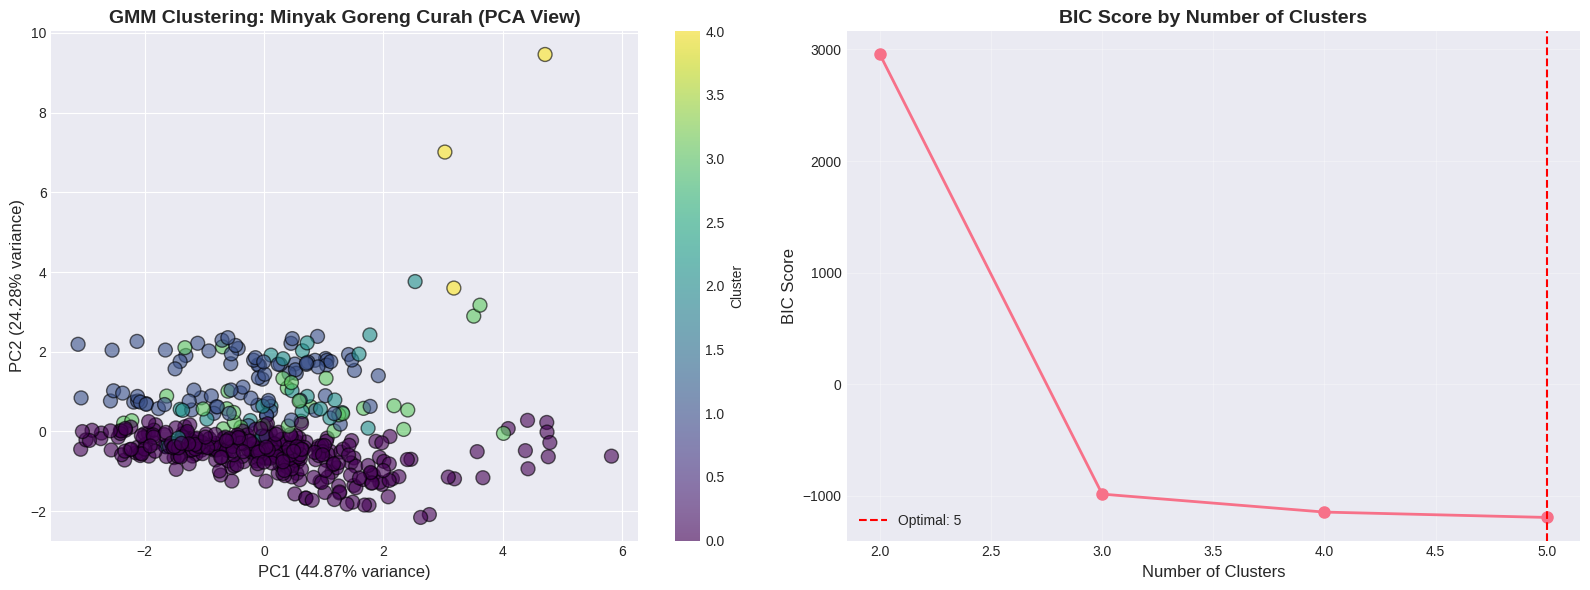

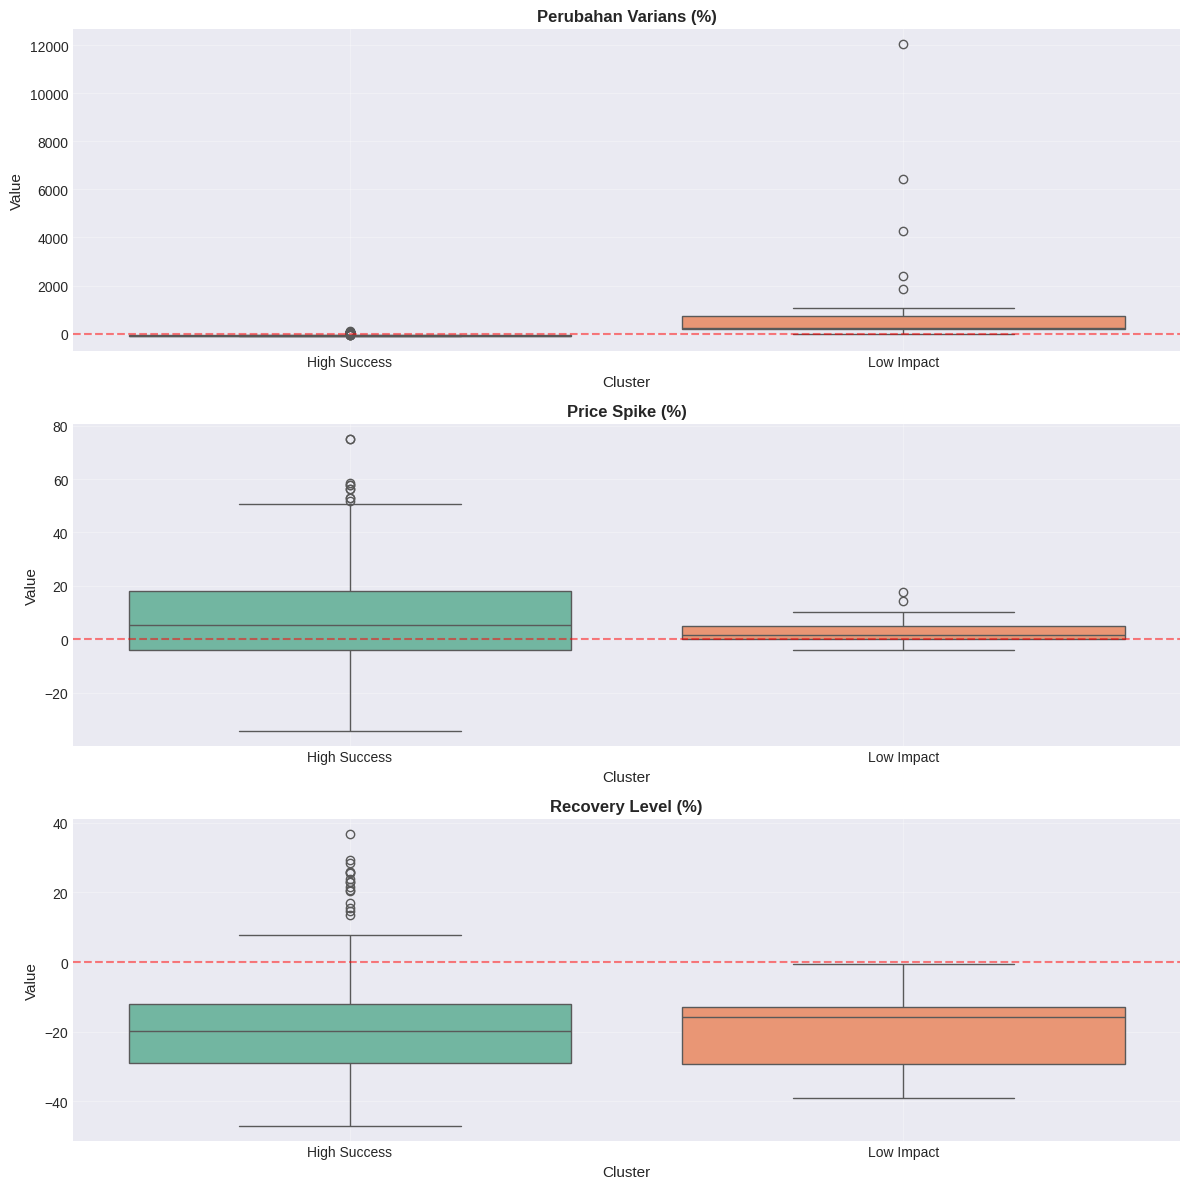

In [17]:
# LANGKAH 4: VISUALISASI - PCA & CLUSTER PLOTS


print("\n" + "=" * 80)
print("LANGKAH 4: VISUALISASI PCA & CLUSTERING")


# PCA untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot 1: PCA Cluster Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA scatter
scatter = axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=cluster_data_clean['Cluster'],
    cmap='viridis',
    s=100,
    alpha=0.6,
    edgecolors='black'
)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[0].set_title('GMM Clustering: Minyak Goreng Curah (PCA View)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# BIC scores
axes[1].plot(n_components_range, bic_scores, marker='o', linewidth=2, markersize=8)
axes[1].axvline(optimal_n, color='red', linestyle='--', label=f'Optimal: {optimal_n}')
axes[1].set_xlabel('Number of Clusters', fontsize=12)
axes[1].set_ylabel('BIC Score', fontsize=12)
axes[1].set_title('BIC Score by Number of Clusters', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot_pca_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Cluster Characteristics
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

metrics = ['Variance_Change_Post1', 'Price_Spike', 'Recovery_Level']
titles = ['Perubahan Varians (%)', 'Price Spike (%)', 'Recovery Level (%)']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    sns.boxplot(
        data=cluster_data_clean,
        x='Cluster_Label',
        y=metric,
        ax=axes[i],
        palette='Set2'
    )
    axes[i].set_title(title, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Cluster', fontsize=11)
    axes[i].set_ylabel('Value', fontsize=11)
    axes[i].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot_cluster_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()



LANGKAH 5: VISUALISASI SPASIAL
Merged GADM and cluster data at KabKot level: 502 features.

Generating interactive map for all provinces...
Interactive map for provinces saved: map_cluster_provinces.html

Generating interactive map for Kota/Kabupaten in Jawa Barat...
Interactive map for Jawa Barat districts/cities saved: map_cluster_jawa_barat.html


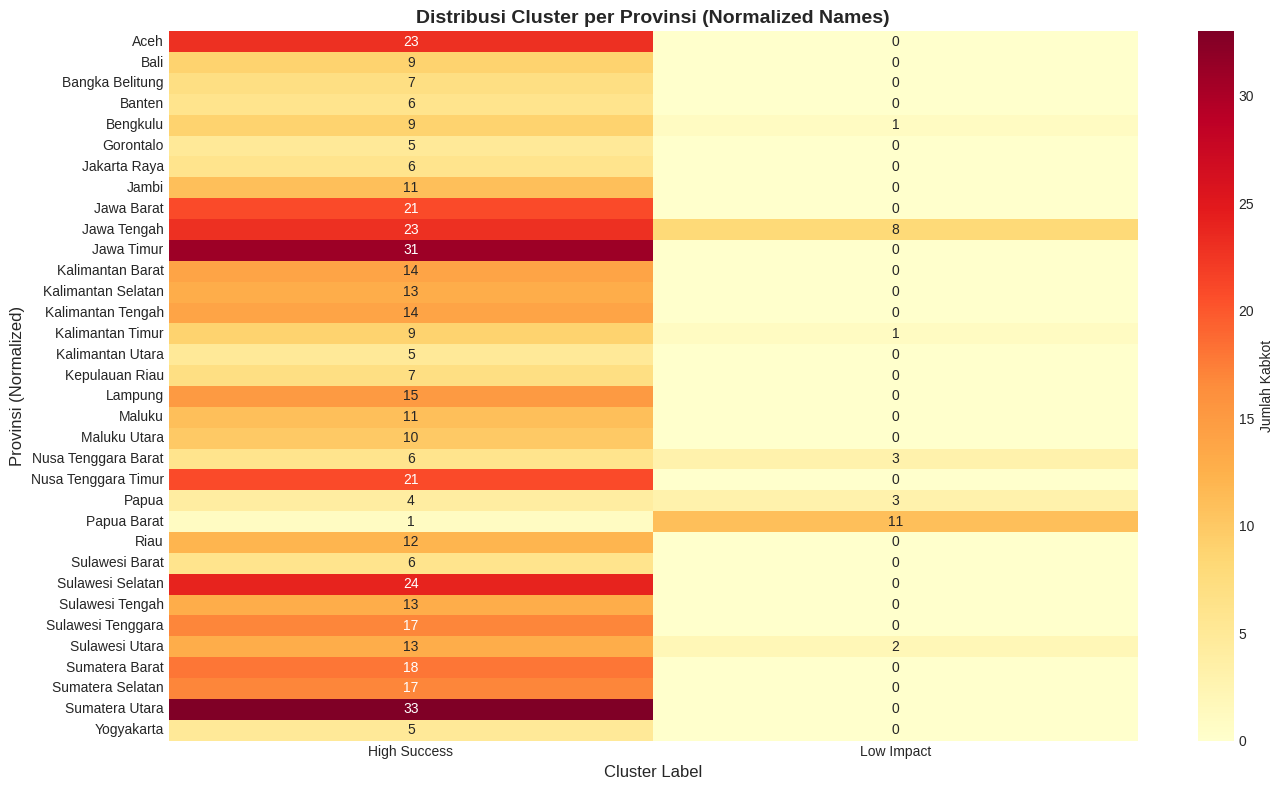

In [18]:

# LANGKAH 5: VISUALISASI SPASIAL


print("\n" + "=" * 80)
print("LANGKAH 5: VISUALISASI SPASIAL")


# Add original NamaProv to cluster_data_clean for merging with GADM
# cluster_data_clean already has KabKot, NamaProv, KabKot
# We need to add the 'NamaProv' (original name) column.

# Check if 'NamaProv' column exists before merging to avoid MergeError on re-run
if 'NamaProv' not in cluster_data_clean.columns:
    kabkot_prov_map = data_analysis[['KabKot', 'NamaProv', 'KabKot', 'NamaProv']].drop_duplicates()
    cluster_data_clean = cluster_data_clean.merge(
        kabkot_prov_map[['KabKot', 'NamaProv', 'NamaProv']], # Select only necessary columns from right df
        on=['KabKot', 'NamaProv'], # Merge on existing keys in cluster_data_clean
        how='left'
    )

# Define color map for clusters
cluster_colors = {
    'High Success': '#2ca02c',       # Green
    'Moderate Success': '#1f77b4',   # Blue
    'Low Impact': '#d62728',         # Red
    'Mixed': '#ff7f0e',              # Orange
    'Unknown': '#8c564b'             # Brown for unmatched, if any
}

# --- Prepare data for spatial visualization ---
# Merge cluster results with GADM data at the KabKot level
# Ensure gadm_gdf is available from previous cells
if 'gadm_gdf' in locals() and gadm_gdf is not None and not gadm_gdf.empty:
    merged_kabkot_gdf = gadm_gdf.merge(
        cluster_data_clean,
        left_on=['KabKot_GADM', 'NamaProv_GADM'],
        right_on=['KabKot', 'NamaProv'],
        how='left' # Use left merge to keep all GADM kabkots, fill unmatched with 'Unknown'
    )
    merged_kabkot_gdf['Cluster_Label'] = merged_kabkot_gdf['Cluster_Label'].fillna('Unknown')
    print(f"Merged GADM and cluster data at KabKot level: {len(merged_kabkot_gdf)} features.")

    # --- Map 1: Seluruh Provinsi di Indonesia (aggregated cluster label) ---
    print("\nGenerating interactive map for all provinces...")

    # Aggregate cluster_data_clean to determine dominant cluster per province
    # Define a custom aggregation function for dominant cluster based on priority
    def get_dominant_cluster(labels_series):
        # Convert to a list of strings to ensure 'in' operator works as expected
        unique_labels = labels_series.unique().tolist()
        if 'Low Impact' in unique_labels:
            return 'Low Impact'
        elif 'Moderate Success' in unique_labels:
            return 'Moderate Success'
        elif 'High Success' in unique_labels:
            return 'High Success'
        else:
            return 'Unknown' # Fallback for provinces without any cluster data

    province_dominant_cluster_agg = cluster_data_clean.groupby('NamaProv').agg(
        Dominant_Cluster_Label=('Cluster_Label', get_dominant_cluster)
    ).reset_index()

    # Dissolve merged_kabkot_gdf to get province boundaries
    # We only need geometry and the GADM province name for the dissolve
    merged_province_gdf = merged_kabkot_gdf[['NamaProv_GADM', 'geometry']].dissolve(by='NamaProv_GADM')
    merged_province_gdf = merged_province_gdf.reset_index()

    # Merge the computed dominant cluster labels
    merged_province_gdf = merged_province_gdf.merge(
        province_dominant_cluster_agg.rename(columns={'NamaProv': 'NamaProv_GADM'}),
        on='NamaProv_GADM',
        how='left'
    )
    # Fill any unmatched provinces (e.g., in GADM but no cluster data) with 'Unknown'
    merged_province_gdf['Dominant_Cluster_Label'] = merged_province_gdf['Dominant_Cluster_Label'].fillna('Unknown')


    m_province = folium.Map(location=[-2.5, 118], zoom_start=5, tiles='OpenStreetMap')

    for _, r in merged_province_gdf.iterrows():
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {
                                   'fillColor': cluster_colors.get(r['Dominant_Cluster_Label'], 'gray'),
                                   'color': 'black',
                                   'weight': 0.5,
                                   'fillOpacity': 0.7
                               })
        folium.Popup(f"Provinsi: {r['NamaProv_GADM'].title()}<br>Dominant Cluster: {r['Dominant_Cluster_Label']} ").add_to(geo_j)
        geo_j.add_to(m_province)

    m_province.save('map_cluster_provinces.html')
    print("Interactive map for provinces saved: map_cluster_provinces.html")

    # --- Map 2: Kota/Kabupaten di Jawa Barat ---
    print("\nGenerating interactive map for Kota/Kabupaten in Jawa Barat...")
    jabar_kabkot_gdf = merged_kabkot_gdf[merged_kabkot_gdf['NamaProv_GADM'] == 'jawa barat'].copy()

    m_jabar = folium.Map(location=[-6.9, 107.6], zoom_start=8, tiles='OpenStreetMap') # Centered on West Java

    if not jabar_kabkot_gdf.empty:
        for _, r in jabar_kabkot_gdf.iterrows():
            sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
            geo_j = sim_geo.to_json()
            geo_j = folium.GeoJson(data=geo_j,
                                   style_function=lambda x: {
                                       'fillColor': cluster_colors.get(r['Cluster_Label'], 'gray'),
                                       'color': 'black',
                                       'weight': 0.5,
                                       'fillOpacity': 0.7
                                   })
            folium.Popup(f"Kabupaten/Kota: {r['KabKot_GADM'].title()}<br>Provinsi: {r['NamaProv_GADM'].title()}<br>Cluster: {r['Cluster_Label']}").add_to(geo_j)
            geo_j.add_to(m_jabar)
    else:
        folium.Marker(
            location=[-6.9, 107.6],
            popup="No cluster data for Jawa Barat districts/cities"
        ).add_to(m_jabar)

    m_jabar.save('map_cluster_jawa_barat.html')
    print("Interactive map for Jawa Barat districts/cities saved: map_cluster_jawa_barat.html")

else:
    print("GADM GeoDataFrame is not available or empty. Skipping spatial map visualizations.")


# Agregasi ke level provinsi untuk Heatmap
# Need to ensure cluster_data_clean has NamaProv for this
clustering_province = cluster_data_clean.groupby(['NamaProv', 'Cluster_Label']).agg({
    'KabKot': 'count',
    'Variance_Change_Post1': 'mean',
    'Probability': 'mean'
}).reset_index()
clustering_province.columns = ['NamaProv', 'Cluster_Label', 'n_kabkot', 'Avg_Variance_Change', 'Avg_Probability']

# Static visualization: Heatmap provinsi
fig, ax = plt.subplots(figsize=(14, 8))
pivot_map = clustering_province.pivot_table(
    index='NamaProv', # Use NamaProv here
    columns='Cluster_Label',
    values='n_kabkot',
    fill_value=0
)

sns.heatmap(pivot_map, annot=True, fmt='g', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Jumlah Kabkot'})
ax.set_title('Distribusi Cluster per Provinsi (Normalized Names)', fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster Label', fontsize=12)
ax.set_ylabel('Provinsi (Normalized)', fontsize=12)

plt.tight_layout()
plt.savefig('plot_spatial_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# LANGKAH 5.1: VISUALISASI SPASIAL DETAIL UNTUK SEMUA KOTA/KABUPATEN


print("\n" + "=" * 80)
print("LANGKAH 5.1: VISUALISASI SPASIAL DETAIL SEMUA KOTA/KABUPATEN")


# Ensure cluster_colors is defined (from previous cell)
cluster_colors = {
    'High Success': '#2ca02c',       # Green
    'Moderate Success': '#1f77b4',   # Blue
    'Low Impact': '#d62728',         # Red
    'Mixed': '#ff7f0e',              # Orange
    'Unknown': '#8c564b'             # Brown for unmatched, if any
}

# Ensure merged_kabkot_gdf is available from the previous run
if 'merged_kabkot_gdf' in locals() and merged_kabkot_gdf is not None and not merged_kabkot_gdf.empty:
    print("\nGenerating interactive map for ALL Kota/Kabupaten in Indonesia...")

    # Initialize map centered on Indonesia
    m_all_kabkot = folium.Map(location=[-2.5, 118], zoom_start=5, tiles='OpenStreetMap')

    # Add each kabkot polygon to the map
    for _, r in merged_kabkot_gdf.iterrows():
        if r['geometry'] is not None: # Check if geometry exists
            sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
            geo_j = sim_geo.to_json()
            geo_j = folium.GeoJson(data=geo_j,
                                   style_function=lambda x: {
                                       'fillColor': cluster_colors.get(r['Cluster_Label'], 'gray'),
                                       'color': 'black',
                                       'weight': 0.5,
                                       'fillOpacity': 0.7
                                   })
            folium.Popup(f"Kabupaten/Kota: {r['KabKot_GADM'].title()}<br>Provinsi: {r['NamaProv_GADM'].title()}<br>Cluster: {r['Cluster_Label']}").add_to(geo_j)
            geo_j.add_to(m_all_kabkot)

    m_all_kabkot.save('map_cluster_all_kabkot.html')
    print("Interactive map for ALL Kota/Kabupaten saved: map_cluster_all_kabkot.html")

else:
    print("merged_kabkot_gdf GeoDataFrame is not available or empty. Skipping detailed spatial map visualization.")



LANGKAH 5.1: VISUALISASI SPASIAL DETAIL SEMUA KOTA/KABUPATEN
merged_kabkot_gdf GeoDataFrame is not available or empty. Skipping detailed spatial map visualization.


In [ ]:
# LANGKAH 6: TIME SERIES VISUALIZATION BY CLUSTER


print("\n" + "=" * 80)
print("LANGKAH 6: TIME SERIES ANALYSIS")


# Merge cluster labels dengan time series data
ts_data = data_analysis[
    data_analysis['Produk'] == 'Minyak Goreng Curah'
].merge(
    cluster_data_clean[['KabKot', 'Cluster_Label']],
    on='KabKot',
    how='inner'
)

# Aggregate by date and cluster
ts_aggregated = ts_data.groupby(['Tanggal', 'Cluster_Label']).agg({
    'Harga': ['mean', 'std']
}).reset_index()
ts_aggregated.columns = ['Tanggal', 'Cluster_Label', 'Mean_Price', 'Std_Price']

# Plot
fig, ax = plt.subplots(figsize=(16, 8))

for label in ts_aggregated['Cluster_Label'].unique():
    data_subset = ts_aggregated[ts_aggregated['Cluster_Label'] == label]

    ax.plot(data_subset['Tanggal'], data_subset['Mean_Price'],
            label=label, linewidth=2)

    ax.fill_between(
        data_subset['Tanggal'],
        data_subset['Mean_Price'] - data_subset['Std_Price'],
        data_subset['Mean_Price'] + data_subset['Std_Price'],
        alpha=0.2
    )

# Event markers
ax.axvline(event_date, color='red', linestyle='--', linewidth=2, label='Larangan Ekspor CPO')
ax.axvline(minyakita_launch, color='blue', linestyle='--', linewidth=2, label='Peluncuran Minyakita')

ax.set_xlabel('Tanggal', fontsize=12)
ax.set_ylabel('Harga Rata-rata (Rp/Kg)', fontsize=12)
ax.set_title('Dinamika Harga Minyak Curah per Cluster', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot_timeseries_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

# LANGKAH 7: STATISTICAL TESTING


print("\n" + "=" * 80)
print("LANGKAH 7: STATISTICAL HYPOTHESIS TESTING")


# ANOVA: Perbedaan variance change antar cluster
groups = [group['Variance_Change_Post1'].values
          for name, group in cluster_data_clean.groupby('Cluster_Label')]

f_stat, p_value = f_oneway(*groups)
print(f"\nANOVA Test - Variance Change antar Cluster:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")

if p_value < 0.05:
    print("✓ Ada perbedaan signifikan antar cluster (p < 0.05)")
else:
    print("✗ Tidak ada perbedaan signifikan antar cluster")

# Tukey HSD Post-hoc
tukey_result = pairwise_tukeyhsd(
    cluster_data_clean['Variance_Change_Post1'],
    cluster_data_clean['Cluster_Label'],
    alpha=0.05
)
print("\n=== Tukey HSD Post-hoc Test ===")
print(tukey_result)

# Convergence Test: CV over time
convergence_test = data_analysis[
    data_analysis['Produk'] == 'Minyak Goreng Curah'
].groupby(['Periode', 'Tanggal']).agg({
    'Harga': lambda x: x.std() / x.mean()  # CV
}).reset_index()
convergence_test.columns = ['Periode', 'Tanggal', 'CV']
convergence_test = convergence_test[convergence_test['Periode'] != 'Other']

# Plot convergence
fig, ax = plt.subplots(figsize=(14, 6))

for periode in convergence_test['Periode'].unique():
    data_subset = convergence_test[convergence_test['Periode'] == periode]
    ax.plot(data_subset['Tanggal'], data_subset['CV'],
            label=periode, linewidth=2, marker='o', markersize=3)

ax.set_xlabel('Tanggal', fontsize=12)
ax.set_ylabel('Coefficient of Variation', fontsize=12)
ax.set_title('Konvergensi Harga: CV Over Time\n(Penurunan CV = Berkurangnya Disparitas Antar Wilayah)',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot_convergence_test.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:

# LANGKAH 8: EXPORT HASIL


print("\n" + "=" * 80)
print("LANGKAH 8: EXPORT HASIL")


# Export clustering results
cluster_data_clean.to_csv('clustering_results_curah.csv', index=False)
cluster_interpretation.to_csv('cluster_interpretation.csv', index=False)
clustering_province.to_csv('clustering_province_summary.csv', index=False)

print("\n✓ File berhasil di-export:")
print("  - clustering_results_curah.csv")
print("  - cluster_interpretation.csv")
print("  - clustering_province_summary.csv")


# RINGKASAN FINAL


print("\n" + "=" * 80)
print("RINGKASAN ANALISIS")


print(f"\nJumlah Cluster Optimal: {optimal_n}")
print(f"BIC Score: {gmm_model.bic(X_scaled):.2f}")

print("\n=== Distribusi Kabupaten/Kota per Cluster ===")
print(cluster_data_clean['Cluster_Label'].value_counts())

print("\n=== Karakteristik Cluster ===")
print(cluster_interpretation.to_string(index=False))

print("\n" + "=" * 80)